In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

In [2]:
def calc_pct_increase_decrease(val1, val2):
    #first value (val1) is assumed to be original or starting values and val2 is ending values
    #check if calculating increase or decreas
    if (val1 - val2) < 0:
        inc=True
    else:
        inc=False

    if inc==False: # decrease
        pct_inc_dec = (((val1 - val2)/val1)*100)

    if inc: #increase
        pct_inc_dec = (((val2 - val1)/val1)*100)
    return pct_inc_dec, inc

def pct_inc_dec_2methods(modified, method1, method2, scenario):
    meth1 = modified[(modified["method"]==method1) & (modified["Mean/std"]=="Mean") & (modified["scenario"]==scenario)].copy()
    meth2 = modified[(modified["method"]==method2) & (modified["Mean/std"]=="Mean") & (modified["scenario"]==scenario)].copy()
    inc_dec_res = []
    for col in meth1.columns:
        if pd.api.types.is_numeric_dtype(meth1[col])==False: continue #Skip columns that are not numeric
        if col == "n_folds":continue
        #print(col, pd.api.types.is_numeric_dtype(meth1[col]))

        #get values to use
        val1 = meth1[col].iloc[0]
        val2 = meth2[col].iloc[0]

        #calculate % increase or decrease
        pct_inc_dec, inc = calc_pct_increase_decrease(val1, val2)

        #place values in list
        inc_dec_res.append([scenario, method1, method2, col, val1, val2, pct_inc_dec, inc])
    inc_dec_res = pd.DataFrame(inc_dec_res, columns=["scenario", "method1", "method2", "column", "val1", "val2", "pct_inc_dec", "increase"])
    return inc_dec_res

In [3]:
#import final summary results files from various methods

In [4]:
#The ensamble one contains many results so just pick the best based on validation set
out_res = pd.read_csv("../data/Results/Summary_results_multi_method_ensmbles_13Nov2020.csv")
#find the best ensmbles based on validation set
tmp = out_res[out_res["set"]=="validation_Final"].reset_index(drop=True).copy()
#do some orginizational magic
tmp = tmp.pivot(index="method",columns="Mean/std").sort_values([("scenario","Mean"),("RMSE","Mean")]).copy()
tmp = pd.DataFrame(tmp.stack()).reset_index()
val_picks=tmp.drop_duplicates(["scenario","Mean/std"])["method"].unique().tolist()
#tmp.drop_duplicates(["scenario","Mean/std"])
out_res = out_res[(out_res["set"]=="test_Final") & (out_res["method"].isin(val_picks))]

In [5]:
#import final summary results files from other methods
files = ["../data/Results/Summary_results_all_02Nov2020.csv",
         "../../Washburn_repos/apsim_genotype_calibrator/data/Apsim_files/Classic/Calibrations/Standard_cultivars_pltArea_results/Summary_results_apsim_18Nov2020.csv"]
dfs=[]
for fl in files:
    dfs.append(pd.read_csv(fl))

dfs.append(out_res)
sum_res = pd.concat(dfs)
sum_res = sum_res.drop(columns="set").reset_index(drop=True)

In [6]:
#do some orginizational magic and sorting
tmp=sum_res.pivot(index="method",columns="Mean/std").sort_values([("scenario","Mean"),("RMSE","Mean")]).copy()
sum_res = pd.DataFrame(tmp.stack()).reset_index()
means = sum_res[sum_res["Mean/std"] == "Mean"][["method","Mean/std","prsn","slope","r2","RMSE","rRMSE","normRMSE","n_folds",
                                        "scenario"]].copy()
stds = sum_res[sum_res["Mean/std"] == "Std"][["method","Mean/std","prsn","slope","r2","RMSE","rRMSE","normRMSE","n_folds",
                                        "scenario"]].copy()
overalls = sum_res[sum_res["Mean/std"] == "Overall"][["method","Mean/std","prsn","slope","r2","RMSE","rRMSE","normRMSE","n_folds",
                                        "scenario"]].copy()
final_sums_out = pd.concat([means,stds,overalls])

In [7]:
#create simplified method names for each
final_sums_out["Long_method"] = final_sums_out["method"]
method_names = {'APSIM_yield_FlwTm_repsTrain_val_test_sets_13_Dec2019':'CGM FTCal',
'APSIM_yield_FlwTm_repsTrain_val_test_sets_Practical_GEM_26Feb2020':'CGM FTCal',
'APSIM_yield_FlwrTm_repsTrain_val_test_sets_E_dwnSample293_24Apr2020':'CGM FTCal',
'APSIM_yield_FlwrTm_repsTrain_val_test_sets_G_dwnSample12_23Apr2020':'CGM FTCal',

'APSIM_yield_repsTrain_val_test_sets_13_Dec2019':'AUTO CGM',
'APSIM_yield_repsTrain_val_test_sets_E_dwnSample293_24Apr2020':'AUTO CGM',
'APSIM_yield_repsTrain_val_test_sets_G_dwnSample12_23Apr2020':'AUTO CGM',
'APSIM_yield_repsTrain_val_test_sets_Practical_GEM_26Feb2020':'AUTO CGM',

'E_GR_13_Dec2019':"E BLUP",
'E_GR_E_dwnSample293_24Apr2020':"E BLUP",
'E_GR_G_dwnSample12_23Apr2020':"E BLUP",
'E_GR_Practical_GEM_26Feb2020':"E BLUP",

'G2FonHist_GEM_reps_val_training_13_Dec2019':'CNN G2F on Hist',
'G2FonHist_reps_val_training_E_dwnSample293_24Apr2020':'CNN G2F on Hist',
'G2FonHist_reps_val_training_G_dwnSample12_23Apr2020':'CNN G2F on Hist',
'G2FonHist_reps_val_training_Practical_GEM_26Feb2020':'CNN G2F on Hist',

'GE_GR_13_Dec2019':"GE BLUP",
'GE_GR_E_dwnSample293_24Apr2020':"GE BLUP",
'GE_GR_G_dwnSample12_23Apr2020':"GE BLUP",
'GE_GR_Practical_GEM_26Feb2020':"GE BLUP",
    
'G_GR_13_Dec2019':"G BLUP",
'G_GR_E_dwnSample293_24Apr2020':"G BLUP",
'G_GR_G_dwnSample12_23Apr2020':"G BLUP",
'G_GR_Practical_GEM_26Feb2020':"G BLUP",

'GxE_GR_13_Dec2019':"GxE BLUP",
'GxE_GR_E_dwnSample293_24Apr2020':"GxE BLUP",
'GxE_GR_G_dwnSample12_23Apr2020':"GxE BLUP",
'GxE_GR_Practical_GEM_26Feb2020':"GxE BLUP",

#AD blup called D BLUP
'G-AD_GR_GEM_Hard_13Dec2019':"D BLUP",
'G-AD_GR_E_dwnSample293_24Apr2020':"D BLUP",
'G-AD_GR_G_dwnSample12_23Apr2020':"D BLUP",
'G-AD_GR_Practical_GEM_26Feb2020':"D BLUP",
                
'GE-AD_GR_GEM_Hard_13Dec2019':"DE BLUP",
'GE-AD_GR_E_dwnSample293_24Apr2020':"DE BLUP",
'GE-AD_GR_G_dwnSample12_23Apr2020':"DE BLUP",
'GE-AD_GR_Practical_GEM_26Feb2020':"DE BLUP",

'GxE-AD_GR_GEM_Hard_13Dec2019':"DxE BLUP",
'GxE-AD_GR_E_dwnSample293_24Apr2020':"DxE BLUP",
'GxE-AD_GR_G_dwnSample12_23Apr2020':"DxE BLUP",
'GxE-AD_GR_Practical_GEM_26Feb2020':"DxE BLUP",         

'reps_val_training_MLP_large13_Dec2019':"MLP",
'reps_val_training_MLP_largeE_dwnSample293_24Apr2020':"MLP",
'reps_val_training_MLP_largeG_dwnSample12_23Apr2020':"MLP",
'reps_val_training_MLP_largePractical_GEM_26Feb2020':"MLP",

'GEM_reps_val_training_13_Dec2019':"CNN",
'reps_val_training_E_dwnSample293_24Apr2020':"CNN",
'reps_val_training_G_dwnSample12_23Apr2020':"CNN",
'reps_val_training_Practical_GEM_26Feb2020':"CNN",
    
'reps_val_training_NO_HIST_13_Dec2019':"CNN NO HIST",
'reps_val_training_NO_HIST_E_dwnSample293_24Apr2020':"CNN NO HIST",
'reps_val_training_NO_HIST_G_dwnSample12_23Apr2020':"CNN NO HIST",
'reps_val_training_NO_HIST_Practical_GEM_26Feb2020':"CNN NO HIST",

'reps_val_training_NO_G_E_dwnSample293_24Apr2020':'CNN NO G',
'reps_val_training_NO_G_G_dwnSample12_23Apr2020':'CNN NO G',
'reps_val_training_NO_G_Practical_GEM_26Feb2020':'CNN NO G',
'reps_val_training_NO_G_13_Dec2019':'CNN NO G',

'reps_val_training_NO_SOIL_13_Dec2019':"CNN NO SOIL",
'reps_val_training_NO_SOIL_E_dwnSample293_24Apr2020':"CNN NO SOIL",
'reps_val_training_NO_SOIL_G_dwnSample12_23Apr2020':"CNN NO SOIL",
'reps_val_training_NO_SOIL_Practical_GEM_26Feb2020':"CNN NO SOIL",
                
'reps_val_training_NO_WEATH_13_Dec2019':"CNN NO WEATH",
'reps_val_training_NO_WEATH_E_dwnSample293_24Apr2020':"CNN NO WEATH",
'reps_val_training_NO_WEATH_G_dwnSample12_23Apr2020':"CNN NO WEATH",
'reps_val_training_NO_WEATH_Practical_GEM_26Feb2020':"CNN NO WEATH",
                
'reps_val_training_RM_LOWSOIL_13_Dec2019':'CNN RM MISS SOIL',
'reps_val_training_RM_LOWSOIL_E_dwnSample293_24Apr2020':'CNN RM MISS SOIL',
'reps_val_training_RM_LOWSOIL_G_dwnSample12_23Apr2020':'CNN RM MISS SOIL',
'reps_val_training_RM_LOWSOIL_Practical_GEM_26Feb2020':'CNN RM MISS SOIL',

'reps_val_training_NO_GYPS_13_Dec2019':'CNN NO GYPSUM',
'reps_val_training_NO_GYPS_E_dwnSample293_24Apr2020':'CNN NO GYPSUM',
'reps_val_training_NO_GYPS_G_dwnSample12_23Apr2020':'CNN NO GYPSUM',
'reps_val_training_NO_GYPS_Practical_GEM_26Feb2020':'CNN NO GYPSUM',

'reps_val_training_NO_G_HIST_E_dwnSample293_24Apr2020':'CNN NO G NO HIST',
'reps_val_training_NO_G_HIST_G_dwnSample12_23Apr2020':'CNN NO G NO HIST',
'reps_val_training_NO_G_HIST_Practical_GEM_26Feb2020':'CNN NO G NO HIST',
'reps_val_training_NO_G_HIST_13_Dec2019':'CNN NO G NO HIST',
                
'reps_val_training_NO_SOIL_NO_HIST_13_Dec2019':"CNN NO SOIL NO HIST",
'reps_val_training_NO_SOIL_NO_HIST_E_dwnSample293_24Apr2020':"CNN NO SOIL NO HIST",
'reps_val_training_NO_SOIL_NO_HIST_G_dwnSample12_23Apr2020':"CNN NO SOIL NO HIST",
'reps_val_training_NO_SOIL_NO_HIST_Practical_GEM_26Feb2020':"CNN NO SOIL NO HIST",
                
'reps_val_training_NO_WEATH_NO_HIST_13_Dec2019':"CNN NO WEATH NO HIST",
'reps_val_training_NO_WEATH_NO_HIST_E_dwnSample293_24Apr2020':"CNN NO WEATH NO HIST",
'reps_val_training_NO_WEATH_NO_HIST_G_dwnSample12_23Apr2020':"CNN NO WEATH NO HIST",
'reps_val_training_NO_WEATH_NO_HIST_Practical_GEM_26Feb2020':"CNN NO WEATH NO HIST",
                
'reps_val_training_RM_LOWSOIL_NO_HIST_13_Dec2019':'CNN RM MISS SOIL NO HIST',
'reps_val_training_RM_LOWSOIL_NO_HIST_E_dwnSample293_24Apr2020':'CNN RM MISS SOIL NO HIST',
'reps_val_training_RM_LOWSOIL_NO_HIST_G_dwnSample12_23Apr2020':'CNN RM MISS SOIL NO HIST',
'reps_val_training_RM_LOWSOIL_NO_HIST_Practical_GEM_26Feb2020':'CNN RM MISS SOIL NO HIST',

'reps_val_training_NO_GYPS_NO_HIST_13_Dec2019':'CNN NO GYPSUM NO HIST',
'reps_val_training_NO_GYPS_NO_HIST_E_dwnSample293_24Apr2020':'CNN NO GYPSUM NO HIST',
'reps_val_training_NO_GYPS_NO_HIST_G_dwnSample12_23Apr2020':'CNN NO GYPSUM NO HIST',
'reps_val_training_NO_GYPS_NO_HIST_Practical_GEM_26Feb2020':'CNN NO GYPSUM NO HIST',

'reps_val_training_G_only_13_Dec2019':"CNN G ONLY NO HIST",
'reps_val_training_G_only_E_dwnSample293_24Apr2020':"CNN G ONLY NO HIST",
'reps_val_training_G_only_G_dwnSample12_23Apr2020':"CNN G ONLY NO HIST",
'reps_val_training_G_only_Practical_GEM_26Feb2020':"CNN G ONLY NO HIST",
                
'reps_val_training_SOIL_only_NO_HIST_13_Dec2019':"CNN SOIL ONLY NO HIST",
'reps_val_training_SOIL_only_NO_HIST_E_dwnSample293_24Apr2020':"CNN SOIL ONLY NO HIST",
'reps_val_training_SOIL_only_NO_HIST_G_dwnSample12_23Apr2020':"CNN SOIL ONLY NO HIST",
'reps_val_training_SOIL_only_NO_HIST_Practical_GEM_26Feb2020':"CNN SOIL ONLY NO HIST",
                
'reps_val_training_FERT_only_13_Dec2019':"CNN FERT ONLY NO HIST",
'reps_val_training_FERT_only_E_dwnSample293_24Apr2020':"CNN FERT ONLY NO HIST",
'reps_val_training_FERT_only_G_dwnSample12_23Apr2020':"CNN FERT ONLY NO HIST",
'reps_val_training_FERT_only_Practical_GEM_26Feb2020':"CNN FERT ONLY NO HIST",
                
'reps_val_training_WEATH_only_NO_HIST_13_Dec2019':"CNN WEATH ONLY NO HIST",
'reps_val_training_WEATH_only_NO_HIST_E_dwnSample293_24Apr2020':"CNN WEATH ONLY NO HIST",
'reps_val_training_WEATH_only_NO_HIST_G_dwnSample12_23Apr2020':"CNN WEATH ONLY NO HIST",
'reps_val_training_WEATH_only_NO_HIST_Practical_GEM_26Feb2020':"CNN WEATH ONLY NO HIST",
                
'reps_val_training_NO_SOIL_NO_HIST_13_Dec2019':"CNN NO SOIL NO HIST",
'reps_val_training_NO_SOIL_NO_HIST_E_dwnSample293_24Apr2020':"CNN NO SOIL NO HIST",
'reps_val_training_NO_SOIL_NO_HIST_G_dwnSample12_23Apr2020':"CNN NO SOIL NO HIST",
'reps_val_training_NO_SOIL_NO_HIST_Practical_GEM_26Feb2020':"CNN NO SOIL NO HIST",
       
'reps_val_training_FIELD_only_NO_HIST_13_Dec2019':"CNN FIELD ONLY NO HIST",
'reps_val_training_FIELD_only_NO_HIST_E_dwnSample293_24Apr2020':"CNN FIELD ONLY NO HIST",
'reps_val_training_FIELD_only_NO_HIST_G_dwnSample12_23Apr2020':"CNN FIELD ONLY NO HIST",
'reps_val_training_FIELD_only_NO_HIST_Practical_GEM_26Feb2020':"CNN FIELD ONLY NO HIST",
}

for key in method_names.keys():
    #print(key, method_names[key])
    final_sums_out["method"] = final_sums_out["method"].str.replace(key, method_names[key])
final_sums_out = final_sums_out[["method","scenario","Mean/std","prsn","slope","r2","RMSE","rRMSE","normRMSE","n_folds","Long_method"]]
#change some names
final_sums_out = final_sums_out.rename(columns={"prsn":"Pearson r", "rRMSE":"Relative RMSE", "normRMSE":"Normalized RMSE"})

In [8]:
final_sums_out

method   scenario Mean/std  \
0                                        CNN NO GYPSUM  E holdout     Mean   
3                                     CNN RM MISS SOIL  E holdout     Mean   
6                                                  CNN  E holdout     Mean   
9    reps_val_training_ReluFinalWeathCons_E_dwnSamp...  E holdout     Mean   
12                                                 MLP  E holdout     Mean   
..                                                 ...        ...      ...   
352                                          CGM FTCal   GEM hard  Overall   
355                             CNN WEATH ONLY NO HIST   GEM hard  Overall   
358                                 CNN G ONLY NO HIST   GEM hard  Overall   
361                                           AUTO CGM   GEM hard  Overall   
364                              CNN SOIL ONLY NO HIST   GEM hard  Overall   

     Pearson r     slope        r2       RMSE  Relative RMSE  Normalized RMSE  \
0     0.314093  0.116319  0.138592  36.572100       0.306751         0.217269   
3     0.319489  0.116763  0.137801  36.695660       0.308648         0.218098   
6     0.321948  0.118319  0.133809  36.811636       0.309713         0.218821   
9     0.313783  0.112902  0.135032  37.060579       0.314792         0.222637   
12    0.312891  0.109506  0.138932  37.122015       0.310930         0.220319   
..         ...       ...       ...        ...            ...              ...   
352   0.263730  0.259779  0.069554  56.264001       0.410659         0.194895   
355  -0.070441 -0.024491  0.004962  57.909851       0.422546         0.200596   
358  -0.035921 -0.018503  0.001290  56.968890       0.415680         0.197336   
361   0.224924  0.222309  0.050591  58.232945       0.425094         0.201715   
364  -0.098901 -0.087800  0.009781  65.557778       0.478350         0.227088   

     n_folds                                        Long_method  
0       74.0  reps_val_training_NO_GYPS_E_dwnSample293_24Apr...  
3       74.0  reps_val_training_RM_LOWSOIL_E_dwnSample293_24...  
6       74.0         reps_val_training_E_dwnSample293_24Apr2020  
9       74.0  reps_val_training_ReluFinalWeathCons_E_dwnSamp...  
12      74.0  reps_val_training_MLP_largeE_dwnSample293_24Ap...  
..       ...                                                ...  
352      NaN  APSIM_yield_FlwTm_repsTrain_val_test_sets_13_D...  
355      NaN    reps_val_training_WEATH_only_NO_HIST_13_Dec2019  
358      NaN                reps_val_training_G_only_13_Dec2019  
361      NaN     APSIM_yield_repsTrain_val_test_sets_13_Dec2019  
364      NaN     reps_val_training_SOIL_only_NO_HIST_13_Dec2019  

[366 rows x 11 columns]

In [9]:
#save final file to disk
final_sums_out.to_csv("../data/Results/Final_result_summarys_ordered_26July2021.csv")

In [9]:
#pd.set_option('display.max_rows', 300)
#final_sums_out

In [9]:
#remove some things/change labels for figures
#change GxE hard APSIM FTcal to CGM
modified = final_sums_out.copy()
#remove other GxE hard APSIM model
#change the correct APSIM FTCal to APSIM


modified = modified[modified["Long_method"]!="APSIM_yield_repsTrain_val_test_sets_13_Dec2019"]
idx = modified[(modified["method"]=="CGM FTCal") & (modified["scenario"]=="GEM hard")].index
modified.loc[idx,"method"]="AUTO CGM"

#rm APSIM FTCal
modified = modified[modified["method"]!="CGM FTCal"]
#rm G2F on HIST
modified = modified[modified["method"]!="CNN G2F on Hist"]
#rm E BLUp
modified = modified[modified["method"]!="E BLUP"]
#combine GE and GxE BLUP, Take the larger of the two and rename it to GE/GxE BLUP
#find Long_method names for the ones to be droped
tmp = modified[(modified["method"].isin(["GE BLUP","GxE BLUP"])) &
         (modified["Mean/std"]=="Mean")].sort_values(["scenario","RMSE"], ascending=False).drop_duplicates("scenario")["Long_method"].to_list()
modified = modified[modified["Long_method"].isin(tmp)==False]
modified["method"] = modified["method"].str.replace('GxE BLUP', "GE/GxE BLUP")
modified["method"] = modified["method"].str.replace('GE BLUP', "GE/GxE BLUP")

tmp = modified[(modified["method"].isin(["DE BLUP","DxE BLUP"])) &
         (modified["Mean/std"]=="Mean")].sort_values(["scenario","RMSE"], ascending=False).drop_duplicates("scenario")["Long_method"].to_list()
modified = modified[modified["Long_method"].isin(tmp)==False]
modified["method"] = modified["method"].str.replace('DxE BLUP', "DE/DxE BLUP")
modified["method"] = modified["method"].str.replace('DE BLUP', "DE/DxE BLUP")

In [10]:
def create_scatter_plot(final_sums_out, scenario, stat):
    tmp = final_sums_out[(final_sums_out["scenario"]==scenario) & final_sums_out["Mean/std"].isin(["Mean","Std"])].copy()
    to_plot = tmp[tmp["Mean/std"]=="Mean"].copy()
    Std = tmp[tmp["Mean/std"]=="Std"].copy()
    StdErr=Std.copy()
    StdErr[stat] = 2*(Std[stat]/np.sqrt(Std["n_folds"]))
    to_plot = to_plot.merge(StdErr, on=["method"])
    to_plot["method"] = to_plot["method"].str.replace(".*&.+","Ensemble")
    #sort
    to_plot = to_plot.sort_values(stat+"_x").reset_index(drop=True)
    #plot
    ax = to_plot.plot.bar(x="method",y=stat+"_x", yerr=stat+"_y", capsize=5, legend=False, edgecolor='black',
                          color="gray") #, hatch="///")
    ax.set_xlabel("")
    ax.set_ylabel(stat)
    ax.set(facecolor = "white")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    #ax.grid(color="lightgray", axis='y')
    plt.show()

E holdout


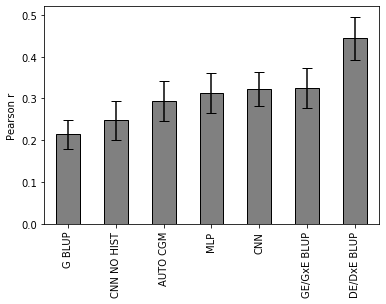

G holdout


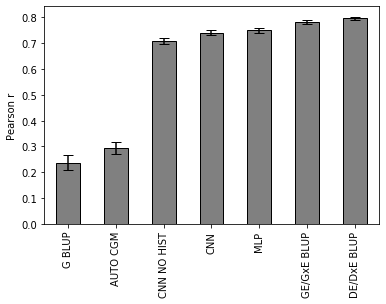

GEM Practical


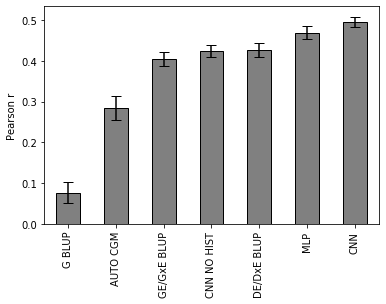

GEM hard


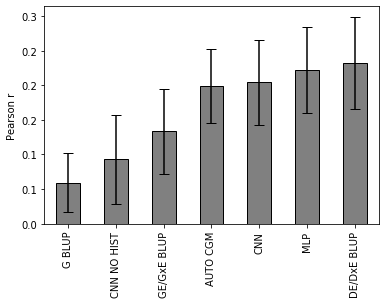

In [11]:
#make some figures

methods_to_plot = ['G BLUP', 'CGM', 'CNN NO HIST', 'AUTO CGM', 'GE/GxE BLUP', "CNN", "MLP", "DE/DxE BLUP"] 
#modified["method"].unique()
for scenario in modified["scenario"].unique():
    print(scenario)
    create_scatter_plot(modified[modified["method"].isin(methods_to_plot)], scenario, stat="Pearson r")


E holdout


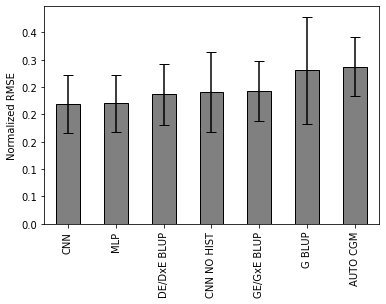

G holdout


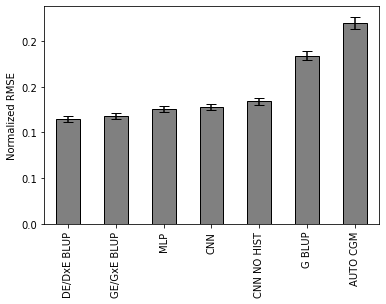

GEM Practical


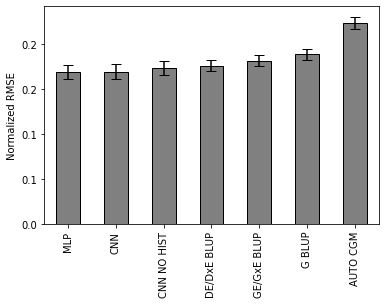

GEM hard


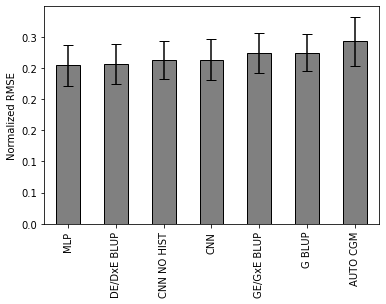

In [12]:
for scenario in modified["scenario"].unique():
    print(scenario)
    create_scatter_plot(modified[modified["method"].isin(methods_to_plot)], scenario, stat="Normalized RMSE")

E holdout


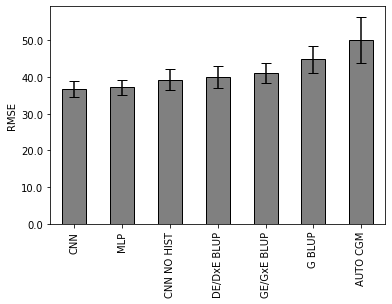

G holdout


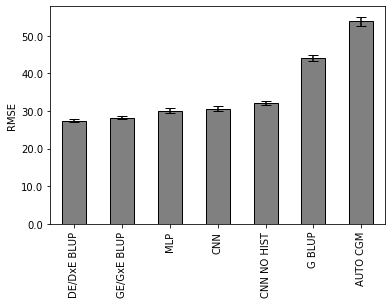

GEM Practical


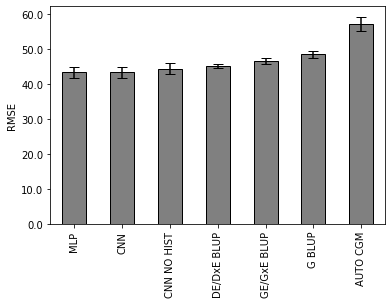

GEM hard


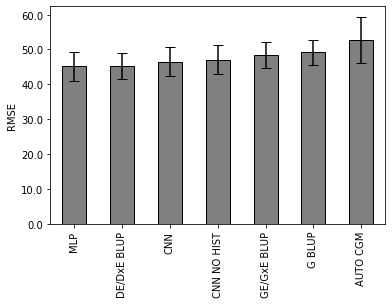

In [13]:
for scenario in modified["scenario"].unique():
    print(scenario)
    create_scatter_plot(modified[modified["method"].isin(methods_to_plot)], scenario, stat="RMSE")

In [23]:
def compare_methods(modified):
    #calculate percentage increase/decrease
    #given two method names, calculate the increase or decrease between them for all variables

    pct_inc_dec_res=[]
    for scenario in modified["scenario"].unique():
        #print(scenario)
        method1="CNN NO HIST"
        method2="CNN"
        pct_inc_dec_res.append(pct_inc_dec_2methods(modified, method1, method2, scenario))

        #compare CNN and CNN NO G
        #method1="CNN NO G"
        #method2="CNN"
        #pct_inc_dec_res.append(pct_inc_dec_2methods(modified, method1, method2, scenario))

        #compare best vs worst.
        tmp = modified[(modified["scenario"]==scenario) & (modified["Mean/std"]=="Mean")].sort_values("RMSE").copy()
        method2 = tmp["method"].iloc[0] #best
        method1 = tmp["method"].iloc[-1] #worst
        pct_inc_dec_res.append(pct_inc_dec_2methods(modified, method1, method2, scenario))

        #compare best CNN vs. best BLUP
        tmp = modified[(modified["scenario"]==scenario) & (modified["Mean/std"]=="Mean")].sort_values("RMSE").copy()
        method2 = tmp[tmp["method"].isin(["CNN", "CNN NO HIST", "MLP"])]["method"].iloc[0] #best CNN
        method1 = tmp[tmp["method"].isin(['GE/GxE BLUP', "DE/DxE BLUP"])]["method"].iloc[0]
        pct_inc_dec_res.append(pct_inc_dec_2methods(modified, method1, method2, scenario))
    pct_inc_dec_res = pd.concat(pct_inc_dec_res)
    
    #create table with all values stacked
    pct_inc_dec_res["for_pivot"] = pct_inc_dec_res["scenario"]+"#"+pct_inc_dec_res["method1"]+"#"+pct_inc_dec_res["method2"]
    pct_inc_dec_pivot = pct_inc_dec_res.pivot(index="for_pivot", columns="column", values=["pct_inc_dec", "increase"])
    pct_inc_dec_pivot = pct_inc_dec_pivot.T.reset_index()
    pct_inc_dec_pivot["new_columns"] = pct_inc_dec_pivot["column"]+" "+pct_inc_dec_pivot["level_0"]
    pct_inc_dec_pivot.index = pct_inc_dec_pivot["new_columns"]
    pct_inc_dec_pivot = pct_inc_dec_pivot.drop(columns=["level_0","column","new_columns"]).sort_index(ascending=False).T
    pct_inc_dec_pivot.reset_index(inplace=True)
    pct_inc_dec_pivot = pd.concat([pct_inc_dec_pivot, pct_inc_dec_pivot["for_pivot"].str.split("#", expand=True)], axis=1)
    pct_inc_dec_pivot = pct_inc_dec_pivot.rename(columns={0:"scenario",1:"method1",2:"method2"}).drop(columns="for_pivot")
    front=["scenario","method1","method2"]
    pct_inc_dec_pivot = pct_inc_dec_pivot[front+[x for x in pct_inc_dec_pivot.columns if x not in front]]
    
    return pct_inc_dec_pivot, pct_inc_dec_res

In [24]:
pct_inc_dec_pivot, pct_inc_dec_res = compare_methods(modified[modified["method"].isin(methods_to_plot)])

In [25]:
pct_inc_dec_pivot[['scenario', 'method1', 'method2', 'Pearson r pct_inc_dec', 'Pearson r increase',
                   'RMSE pct_inc_dec', 'RMSE increase','Relative RMSE pct_inc_dec', 'Relative RMSE increase',
                   'Normalized RMSE pct_inc_dec', 'Normalized RMSE increase']]

scenario      method1      method2 Pearson r pct_inc_dec  \
0       E holdout     AUTO CGM          CNN               9.49971   
1       E holdout  CNN NO HIST          CNN               30.1786   
2       E holdout  DE/DxE BLUP          CNN               27.4597   
3       G holdout     AUTO CGM  DE/DxE BLUP               171.684   
4       G holdout  CNN NO HIST          CNN               4.44337   
5       G holdout  DE/DxE BLUP          MLP               5.79772   
6   GEM Practical     AUTO CGM          MLP               64.3354   
7   GEM Practical  CNN NO HIST          CNN               17.0502   
8   GEM Practical  DE/DxE BLUP          MLP               9.96919   
9        GEM hard     AUTO CGM          MLP               11.7745   
10       GEM hard  CNN NO HIST          CNN               119.062   
11       GEM hard  DE/DxE BLUP          MLP               4.26556   

   Pearson r increase RMSE pct_inc_dec RMSE increase  \
0                True          26.6026         False   
1                True          6.10666         False   
2               False          7.93348         False   
3                True          49.0791         False   
4                True          4.61506         False   
5               False          9.91168          True   
6                True          24.3607         False   
7                True          2.28083         False   
8                True          4.04418         False   
9                True          14.3803         False   
10               True          1.17039         False   
11              False         0.215172         False   

   Relative RMSE pct_inc_dec Relative RMSE increase  \
0                    23.1143                  False   
1                    9.01233                  False   
2                    8.33565                  False   
3                    49.1648                  False   
4                     4.6239                  False   
5                     9.9224                   True   
6                     24.104                  False   
7                    2.16923                  False   
8                    4.20048                  False   
9                    12.7686                  False   
10                  0.120709                  False   
11                   0.98641                   True   

   Normalized RMSE pct_inc_dec Normalized RMSE increase  
0                      23.8497                    False  
1                      9.15976                    False  
2                      7.59185                    False  
3                      47.9622                    False  
4                      4.61832                    False  
5                      9.90549                     True  
6                      24.4993                    False  
7                      2.10645                    False  
8                      4.00585                    False  
9                      13.2103                    False  
10                    0.189934                     True  
11                    0.709844                    False

In [26]:
pct_inc_dec_res[pct_inc_dec_res["column"]=="RMSE"]

scenario      method1      method2 column       val1       val2  \
3      E holdout  CNN NO HIST          CNN   RMSE  39.205801  36.811636   
3      E holdout     AUTO CGM          CNN   RMSE  50.153871  36.811636   
3      E holdout  DE/DxE BLUP          CNN   RMSE  39.983736  36.811636   
3      G holdout  CNN NO HIST          CNN   RMSE  32.087699  30.606833   
3      G holdout     AUTO CGM  DE/DxE BLUP   RMSE  53.794139  27.392472   
3      G holdout  DE/DxE BLUP          MLP   RMSE  27.392472  30.107525   
3  GEM Practical  CNN NO HIST          CNN   RMSE  44.353685  43.342052   
3  GEM Practical     AUTO CGM          MLP   RMSE  57.219349  43.280304   
3  GEM Practical  DE/DxE BLUP          MLP   RMSE  45.104409  43.280304   
3       GEM hard  CNN NO HIST          CNN   RMSE  47.060881  46.510088   
3       GEM hard     AUTO CGM          MLP   RMSE  52.743423  45.158755   
3       GEM hard  DE/DxE BLUP          MLP   RMSE  45.256134  45.158755   

   pct_inc_dec  increase                       for_pivot  
3     6.106659     False       E holdout#CNN NO HIST#CNN  
3    26.602602     False          E holdout#AUTO CGM#CNN  
3     7.933477     False       E holdout#DE/DxE BLUP#CNN  
3     4.615057     False       G holdout#CNN NO HIST#CNN  
3    49.079077     False  G holdout#AUTO CGM#DE/DxE BLUP  
3     9.911678      True       G holdout#DE/DxE BLUP#MLP  
3     2.280832     False   GEM Practical#CNN NO HIST#CNN  
3    24.360718     False      GEM Practical#AUTO CGM#MLP  
3     4.044182     False   GEM Practical#DE/DxE BLUP#MLP  
3     1.170386     False        GEM hard#CNN NO HIST#CNN  
3    14.380310     False           GEM hard#AUTO CGM#MLP  
3     0.215172     False        GEM hard#DE/DxE BLUP#MLP

In [27]:
pct_inc_dec_res[pct_inc_dec_res["column"]=="Normalized RMSE"]

scenario      method1      method2           column      val1  \
5      E holdout  CNN NO HIST          CNN  Normalized RMSE  0.240885   
5      E holdout     AUTO CGM          CNN  Normalized RMSE  0.287354   
5      E holdout  DE/DxE BLUP          CNN  Normalized RMSE  0.236798   
5      G holdout  CNN NO HIST          CNN  Normalized RMSE  0.134207   
5      G holdout     AUTO CGM  DE/DxE BLUP  Normalized RMSE  0.220150   
5      G holdout  DE/DxE BLUP          MLP  Normalized RMSE  0.114562   
5  GEM Practical  CNN NO HIST          CNN  Normalized RMSE  0.172552   
5  GEM Practical     AUTO CGM          MLP  Normalized RMSE  0.223101   
5  GEM Practical  DE/DxE BLUP          MLP  Normalized RMSE  0.175472   
5       GEM hard  CNN NO HIST          CNN  Normalized RMSE  0.262218   
5       GEM hard     AUTO CGM          MLP  Normalized RMSE  0.292607   
5       GEM hard  DE/DxE BLUP          MLP  Normalized RMSE  0.255768   

       val2  pct_inc_dec  increase                       for_pivot  
5  0.218821     9.159755     False       E holdout#CNN NO HIST#CNN  
5  0.218821    23.849733     False          E holdout#AUTO CGM#CNN  
5  0.218821     7.591848     False       E holdout#DE/DxE BLUP#CNN  
5  0.128009     4.618322     False       G holdout#CNN NO HIST#CNN  
5  0.114562    47.962183     False  G holdout#AUTO CGM#DE/DxE BLUP  
5  0.125909     9.905487      True       G holdout#DE/DxE BLUP#MLP  
5  0.168917     2.106448     False   GEM Practical#CNN NO HIST#CNN  
5  0.168443    24.499310     False      GEM Practical#AUTO CGM#MLP  
5  0.168443     4.005853     False   GEM Practical#DE/DxE BLUP#MLP  
5  0.262717     0.189934      True        GEM hard#CNN NO HIST#CNN  
5  0.253952    13.210296     False           GEM hard#AUTO CGM#MLP  
5  0.253952     0.709844     False        GEM hard#DE/DxE BLUP#MLP

In [28]:
pct_inc_dec_res[pct_inc_dec_res["column"]=="Pearson r"]

scenario      method1      method2     column      val1      val2  \
0      E holdout  CNN NO HIST          CNN  Pearson r  0.247313  0.321948   
0      E holdout     AUTO CGM          CNN  Pearson r  0.294018  0.321948   
0      E holdout  DE/DxE BLUP          CNN  Pearson r  0.443820  0.321948   
0      G holdout  CNN NO HIST          CNN  Pearson r  0.709269  0.740785   
0      G holdout     AUTO CGM  DE/DxE BLUP  Pearson r  0.293287  0.796813   
0      G holdout  DE/DxE BLUP          MLP  Pearson r  0.796813  0.750616   
0  GEM Practical  CNN NO HIST          CNN  Pearson r  0.423799  0.496057   
0  GEM Practical     AUTO CGM          MLP  Pearson r  0.285107  0.468532   
0  GEM Practical  DE/DxE BLUP          MLP  Pearson r  0.426057  0.468532   
0       GEM hard  CNN NO HIST          CNN  Pearson r  0.093212  0.204193   
0       GEM hard     AUTO CGM          MLP  Pearson r  0.198970  0.222397   
0       GEM hard  DE/DxE BLUP          MLP  Pearson r  0.232306  0.222397   

   pct_inc_dec  increase                       for_pivot  
0    30.178571      True       E holdout#CNN NO HIST#CNN  
0     9.499710      True          E holdout#AUTO CGM#CNN  
0    27.459711     False       E holdout#DE/DxE BLUP#CNN  
0     4.443365      True       G holdout#CNN NO HIST#CNN  
0   171.684191      True  G holdout#AUTO CGM#DE/DxE BLUP  
0     5.797723     False       G holdout#DE/DxE BLUP#MLP  
0    17.050168      True   GEM Practical#CNN NO HIST#CNN  
0    64.335436      True      GEM Practical#AUTO CGM#MLP  
0     9.969190      True   GEM Practical#DE/DxE BLUP#MLP  
0   119.062065      True        GEM hard#CNN NO HIST#CNN  
0    11.774456      True           GEM hard#AUTO CGM#MLP  
0     4.265559     False        GEM hard#DE/DxE BLUP#MLP

In [21]:
#### MAKE TABLE OF RESULTS from different CNN methods ####

In [22]:
def make_table_scenarios_methods(modified, stat, mean_or_std="Mean"):
    tmp = modified[modified["method"].str.contains("BLUP")==False].copy() #remove blup methods
    tmp = tmp[tmp["method"].str.contains("&")==False] #remove esemble methods
    tmp = tmp[tmp["method"].str.contains("CGM")==False] #remove CGM methods
    tmp = tmp[tmp["Mean/std"]==mean_or_std] #jist use means
    tmp = tmp.pivot(index="method", columns="scenario", values=stat).reset_index()
    tmp["Historical"] = tmp["method"].str.contains("NO HIST")==False
    tmp["G2F_included"] = tmp["method"].str.split("CNN", expand=True)[1].str.split("NO HIST", expand=True)[0].str.strip()
    tmp = tmp.replace([" ",""],"ALL")
    tmp.columns.name = mean_or_std+"-"+stat
    tmp["NOvsONLY"] = tmp["G2F_included"].str.contains("ONLY")==False
    tmp["Historical"] = tmp["Historical"].replace({False:"NO_HIST", True:"HIST"})
    tmp = tmp.sort_values(["Historical","NOvsONLY","G2F_included"]).reset_index(drop=True)
    tmp = tmp[["Historical","G2F_included","E holdout", "G holdout", "GEM Practical", "GEM hard"]]
    tmp.index = tmp["G2F_included"]+" - "+tmp["Historical"]
    return tmp

In [23]:
desired_methods=["CNN","CNN NO G", "CNN NO WEATH", 'CNN NO SOIL', 'CNN RM MISS SOIL', 'CNN NO GYPSUM',
                 'CNN NO HIST', "CNN NO G NO HIST", 'CNN NO WEATH NO HIST','CNN NO SOIL NO HIST',
                 'CNN RM MISS SOIL NO HIST', 'CNN NO GYPSUM NO HIST']

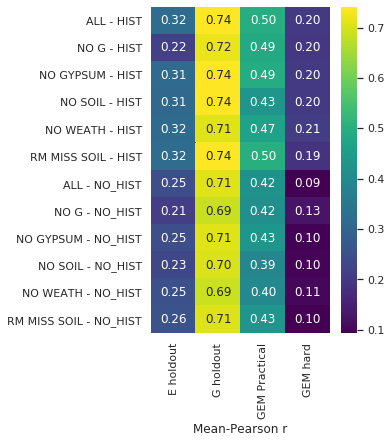

In [24]:
tmp=modified[modified["method"].isin(desired_methods)]
table_mean_r = make_table_scenarios_methods(tmp, stat="Pearson r")
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(4,6))
ax = sns.heatmap(table_mean_r[["E holdout", "G holdout", "GEM Practical", "GEM hard"]], annot=True, fmt=".2f", cmap='viridis')
plt.show()

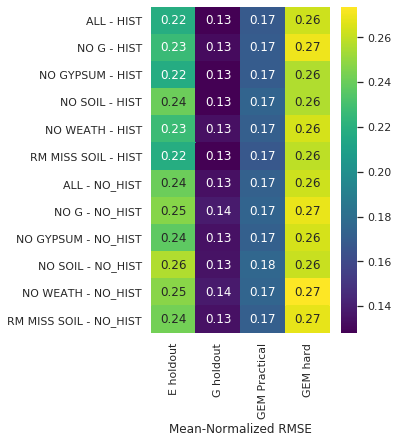

In [25]:
tmp=modified[modified["method"].isin(desired_methods)]
table_mean_nRMSE = make_table_scenarios_methods(tmp, stat="Normalized RMSE")
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(4,6))
ax = sns.heatmap(table_mean_nRMSE[["E holdout", "G holdout", "GEM Practical", "GEM hard"]], annot=True, fmt=".2f", cmap='viridis')
plt.show()